In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import snpytools as snpy
def q(sql):
    return snpy.df_from_presto(sql, user_name = 'devon.bancroft')
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.linear_model import Ridge, Lasso
rreg = Ridge()
lasso = Lasso()
from sklearn.model_selection import cross_val_score
from scipy.stats import probplot
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

### New model= get rid of targeted Pushes, which is too biased. Add in new feature - time difference between first closing the app and getting your first push notification, and use hard news ratio (number of pushes sent in US and Politics vs Entertainment, Lifestyle, etc.)

1) only scheduled and breaking, no targeted
2) D0 through D6 sent count
3) ratio of hard new to soft news (counting personalized scheduled push)
4) time difference between first closing the app and sending first push
5) D7 plus whether they were in 5 weeks after installing

Previous work here: https://jupyter.smartnews.be/user/sn/notebooks/push-notification/2020-01-02-DEVON-PUSH-new_user_activation_project-PART-1.ipynb

User segmentation:
New users who installed in November, and who had ATLEAST ONE PUSH SENT TO THEM AND ALSO A LEAVE FOREGROUND ACTION

In [2]:
df = q('''
SELECT
   a.user_id,
   a.install_dt,
   a.network_name,
   a.platform,
   a.day,
   a.dt,
   COALESCE(b.sent_count, 0) as sent_count,
   COALESCE(LIFESTYLE, 0) as LIFESTYLE,
   COALESCE(ENTERTAINMENT, 0) as ENTERTAINMENT,
   COALESCE(WORLD, 0) as WORLD,
   COALESCE(SCIENCE, 0) as SCIENCE,
   COALESCE(BIZ, 0) as BIZ,
   COALESCE(TECH, 0) as TECH,
   COALESCE(SPORTS, 0) as SPORTS,
   COALESCE(POLITICS,0) as POLITICS,
   COALESCE(NATIONAL, 0) as NATIONAL,
   COALESCE(UNKNOWN, 0) as UNKNOWN,
   (
   CASE
      WHEN
         c.user_id IS NULL
      THEN
         0
      ELSE
         1
   END
) as active_day
FROM
   (
      SELECT
         user_id,
         install_dt,
         platform,
         network_name,
         dt,
         date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) as day
      FROM
         (
            SELECT
               user_id,
               date_format(from_unixtime(creation_timestamp), '%Y-%m-%d') as install_dt,
               network_name,
               platform
            from
               daily_user_installs
            where
               dt BETWEEN '2019-10-01' AND '2019-10-31'
               AND country = 'US'
               AND mod(user_id, 10) = 5
               AND language = 'en'
               AND user_id IN
               (
                  SELECT
                     id
                  from
                     users
                  where
                     dt = '2019-11-07'
                     and j(profile, '$.pushNotificationPermission') = '1'
               )
         )
         a
         CROSS JOIN
            (
               SELECT
                  date as dt
               from
                  analytics.dates
               WHERE
                  date between '2019-10-01' AND '2019-11-07'
            )
            b
      where
         date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) between 0 and 7
   )
   a
   LEFT JOIN
      (
         SELECT
            user_id,
            dt,
            count(distinct push_id) as sent_count
         from
            smartnews.push_episodes
         WHERE
            dt between '2019-10-01' AND '2019-11-07'
            AND edition = 'en_US'
            AND mod(user_id, 10) = 5
            AND split(push_id,'::')[1] <> 'personalizedBreaking'
         GROUP BY
            1, 2
      )
      b
      on b.user_id = a.user_id
      AND b.dt = a.dt

   LEFT JOIN
      (
         SELECT DISTINCT
            dt,
            user_id
         from
            user_activities
         where
            dt between '2019-10-01' AND '2019-11-07'
            and edition = 'en_US'
      )
      c
      on a.user_id = c.user_id
      and c.dt = a.dt
   LEFT JOIN
      (
         SELECT
            user_id,
            dt,
            count_if(cat = 'EN_US_LIFESTYLE') as LIFESTYLE,
            count_if(cat = 'EN_US_ENTERTAINMENT') as ENTERTAINMENT,
            count_if(cat = 'EN_US_WORLD') as WORLD,
            count_if(cat = 'EN_US_SCIENCE') as SCIENCE,
            count_if(cat = 'EN_US_BUSINESS') as BIZ,
            count_if(cat = 'EN_US_TECHNOLOGY') as TECH,
            count_if(cat = 'EN_US_SPORTS') as SPORTS,
            count_if(cat = 'EN_US_POLITICS') as POLITICS,
            count_if(cat = 'EN_US_NATIONAL') as NATIONAL,
            count_if(cat = 'UNKNOWN') as UNKNOWN
         FROM
            (
               SELECT DISTINCT
                  user_id,
                  dt,
                  sent_link_url,
                  cat
               from
                  smartnews.push_episodes ep
                  INNER JOIN
                     (
                        SELECT
                           url,
                           array_min(category) as cat
                        from
                           articles
                        WHERE
                           dt between '2019-09-25' AND '2019-11-10'
                           AND lang = 'EN'
                     )
                     cat
                     on cat.url = ep.sent_link_url
               WHERE
                  ep.dt between '2019-10-01' AND '2019-11-07'
                  AND edition = 'en_US'
                  AND mod(user_id, 10) = 5
                  AND split(push_id,'::')[1] <> 'personalizedBreaking'
            )
         GROUP BY
            1,
            2
      )
      d      
      on a.dt = d.dt
      AND a.user_id = d.user_id''')

SELECT a.user_id,
       a.install_dt,
       a.network_name,
       a.platform,
       a.day,
       a.dt,
       COALESCE(b.sent_count, 0) AS sent_count,
       COALESCE(LIFESTYLE, 0) AS LIFESTYLE,
       COALESCE(ENTERTAINMENT, 0) AS ENTERTAINMENT,
       COALESCE(WORLD, 0) AS WORLD,
       COALESCE(SCIENCE, 0) AS SCIENCE,
       COALESCE(BIZ, 0) AS BIZ,
       COALESCE(TECH, 0) AS TECH,
       COALESCE(SPORTS, 0) AS SPORTS,
       COALESCE(POLITICS, 0) AS POLITICS,
       COALESCE(NATIONAL, 0) AS NATIONAL,
       COALESCE(UNKNOWN, 0) AS UNKNOWN,
       (CASE
            WHEN c.user_id IS NULL THEN 0
            ELSE 1
        END) AS active_day
FROM
  (SELECT user_id,
          install_dt,
          platform,
          network_name,
          dt,
          date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) AS DAY
   FROM
     (SELECT user_id,
             date_format(from_unixtime(creation_timestamp), '%Y-%m-%d') AS install_dt,
             network_nam

In [3]:
df.shape

(680606, 18)

In [4]:
df.head()

,user_id,install_dt,network_name,platform,day,dt,sent_count,LIFESTYLE,ENTERTAINMENT,WORLD,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,active_day
0,104890785,2019-10-02,Android_DigitalTurbine_Verizon_Test,android,0,2019-10-02,0,0,0,0,0,0,0,0,0,0,0,1
1,104890785,2019-10-02,Android_DigitalTurbine_Verizon_Test,android,1,2019-10-03,7,2,3,1,1,0,1,1,4,2,0,0
2,104890785,2019-10-02,Android_DigitalTurbine_Verizon_Test,android,2,2019-10-04,10,1,2,0,1,0,0,1,7,5,0,1
3,104890785,2019-10-02,Android_DigitalTurbine_Verizon_Test,android,3,2019-10-05,4,3,1,0,0,1,0,2,3,3,0,0
4,104890785,2019-10-02,Android_DigitalTurbine_Verizon_Test,android,4,2019-10-06,6,3,2,0,1,0,0,0,4,4,0,0


In [5]:
df_new = df.pivot(index='user_id', columns='day', values='sent_count').reset_index()

In [6]:
df.groupby('user_id').sum()[
    ['NATIONAL', 'POLITICS']].sum(axis=1) / df.groupby('user_id').sum().iloc[:,7:16].sum(axis=1)

user_id
104628555    0.966102
104628565    0.824742
104628655    0.775510
104628675    0.806818
104628705    0.000000
               ...   
109446055    0.605634
109446065    0.696429
109446145    0.688525
109446195    0.694915
109446215    0.666667
Length: 85103, dtype: float64

In [7]:
hard_news = pd.DataFrame(df.groupby('user_id').sum()[
    ['NATIONAL', 'POLITICS']].sum(axis=1) / df.groupby('user_id').sum().iloc[:,7:16].sum(axis=1)).rename({0:'hard_news_ratio'}, axis=1)

In [8]:
df_new.head()

day,user_id,0,1,2,3,4,5,6,7
0,104628555,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0
1,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0
2,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0
3,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0
4,104628705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_new = pd.merge(df_new, hard_news, on='user_id', how='left')

In [10]:
df_new = pd.merge(df_new, df[df.day==7][['user_id','active_day']].rename({'active_day':'D7R'}, axis=1), on='user_id', how='left')

In [11]:
df_new.head()

,user_id,0,1,2,3,4,5,6,7,hard_news_ratio,D7R
0,104628555,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.966102,0
1,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.824742,0
2,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.775510,0
3,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806818,0
4,104628705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0


SQL to get time difference in seconds between first leaveForeground and the next sent push

In [12]:
df_diff = q('''SELECT
   user_id,
   first_sent - first_exit as diff_secs 
FROM
   (
      SELECT
         first_exit.user_id,
         first_exit.first_exit,
         min(first_sent.sent_timestamp) as first_sent 
      FROM
         (
            SELECT
               user_id,
               min(event_timestamp) as first_exit 
            from
               actions 
            WHERE
               action = 'leaveForeground' 
               AND dt between '2019-10-01' AND '2019-11-07' 
               AND edition = 'en_US' 
            GROUP BY
               1
         )
         first_exit 
         INNER join
            (
               SELECT
                  user_id,
                  sent_timestamp 
               from
                  smartnews.push_episodes 
               WHERE
                  user_id IN 
                  (
                     SELECT
                        user_id 
                     from
                        daily_user_installs 
                     where
                        dt BETWEEN '2019-10-01' AND '2019-10-31' 
                        AND country = 'US' 
                        AND mod(user_id, 10) = 5 
                        AND language = 'en'
                  )
                  AND dt between '2019-10-01' AND '2019-11-07' 
                  AND edition = 'en_US' 
            )
            first_sent 
            on first_exit.user_id = first_sent.user_id 
            and first_exit.first_exit < first_sent.sent_timestamp 
      GROUP BY
         1,
         2
   )''')

SELECT user_id,
       first_sent - first_exit AS diff_secs
FROM
  (SELECT first_exit.user_id,
          first_exit.first_exit,
          min(first_sent.sent_timestamp) AS first_sent
   FROM
     (SELECT user_id,
             min(event_timestamp) AS first_exit
      FROM actions
      WHERE action = 'leaveForeground'
        AND dt BETWEEN '2019-10-01' AND '2019-11-07'
        AND edition = 'en_US'
      GROUP BY 1) first_exit
   INNER JOIN
     (SELECT user_id,
             sent_timestamp
      FROM smartnews.push_episodes
      WHERE user_id IN
          (SELECT user_id
           FROM daily_user_installs
           WHERE dt BETWEEN '2019-10-01' AND '2019-10-31'
             AND country = 'US'
             AND mod(user_id, 10) = 5
             AND LANGUAGE = 'en' )
        AND dt BETWEEN '2019-10-01' AND '2019-11-07'
        AND edition = 'en_US' ) first_sent ON first_exit.user_id = first_sent.user_id
   AND first_exit.first_exit < first_sent.sent_timestamp
   GROUP BY 1,
           

In [13]:
df_new.shape

(85103, 11)

In [14]:
df_diff.shape

(78294, 2)

In [15]:
np.sum(df_new.iloc[:,1:9].sum(axis=1) == 0)

7827

7827 users in original dataframe with 0 total pushes

In [16]:
pd.merge(df_new, df_diff, on='user_id', how='inner')

,user_id,0,1,2,3,4,5,6,7,hard_news_ratio,D7R,diff_secs
0,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.824742,0,7291
1,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.775510,0,7235
2,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806818,0,10731
3,104628725,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806122,0,10921
4,104628795,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.583333,1,10728
...,...,...,...,...,...,...,...,...,...,...,...,...
74510,109446055,0.0,6.0,5.0,5.0,8.0,5.0,10.0,6.0,0.605634,1,18137
74511,109446065,0.0,7.0,4.0,5.0,8.0,5.0,10.0,6.0,0.696429,0,7392
74512,109446145,0.0,7.0,4.0,5.0,8.0,5.0,10.0,6.0,0.688525,0,7338
74513,109446195,0.0,7.0,4.0,5.0,8.0,5.0,10.0,6.0,0.694915,0,7210


In [17]:
df_new = pd.merge(df_new, df_diff, on='user_id', how='inner')

In [18]:
np.sum(df_new.iloc[:,1:9].sum(axis=1) == 0)

336

Adding whether users were in MAU 6 weeks (42 days) after install. In other words, counting two weeks after install, were they active for at least one day for the 28 day period?

In [19]:
df_mau_retained = q('''SELECT
   a.user_id,
   a.install_dt,
   (
      CASE
         WHEN
            b.dt IS NOT NULL 
         THEN
            1 
         ELSE
            0 
      END
   )
   as active_MAU 
FROM
   (
      SELECT
         user_id,
         dt as install_dt 
      from
         daily_user_installs 
      WHERE
         dt BETWEEN '2019-10-01' AND '2019-10-31' 
         AND country = 'US' 
         AND mod(user_id, 10) = 5 
         AND language = 'en'
   )
   a 
   LEFT JOIN
      (
         SELECT
            user_id,
            dt 
         from
            daily_user_fq_segment 
         where
            dt BETWEEN '2019-10-01' AND '2019-12-07' 
            AND edition = 'en_US' 
            AND mod(user_id, 10) = 5 
      )
      b 
      on a.user_id = b.user_id 
      and date_diff('day', date_parse(a.install_dt, '%Y-%m-%d'), date_parse(b.dt, '%Y-%m-%d')) = 42

''')

SELECT a.user_id,
       a.install_dt,
       (CASE
            WHEN b.dt IS NOT NULL THEN 1
            ELSE 0
        END) AS active_MAU
FROM
  (SELECT user_id,
          dt AS install_dt
   FROM daily_user_installs
   WHERE dt BETWEEN '2019-10-01' AND '2019-10-31'
     AND country = 'US'
     AND mod(user_id, 10) = 5
     AND LANGUAGE = 'en' ) a
LEFT JOIN
  (SELECT user_id,
          dt
   FROM daily_user_fq_segment
   WHERE dt BETWEEN '2019-10-01' AND '2019-12-07'
     AND edition = 'en_US'
     AND mod(user_id, 10) = 5 ) b ON a.user_id = b.user_id
AND date_diff('day', date_parse(a.install_dt, '%Y-%m-%d'), date_parse(b.dt, '%Y-%m-%d')) = 42
Length of dataframe is 102896
Top 5 rows of the dataframe:
     user_id  install_dt  active_MAU
0  109416845  2019-10-31           0
1  109318125  2019-10-31           0
2  109357115  2019-10-31           0
3  109140935  2019-10-30           0
4  109203525  2019-10-30           0


In [20]:
df_mau_retained.shape

(102896, 3)

In [21]:
pd.merge(df_new, df_mau_retained, on='user_id', how='left')

,user_id,0,1,2,3,4,5,6,7,hard_news_ratio,D7R,diff_secs,install_dt,active_MAU
0,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.824742,0,7291,2019-10-01,0
1,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.775510,0,7235,2019-10-01,0
2,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806818,0,10731,2019-10-01,0
3,104628725,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806122,0,10921,2019-10-01,0
4,104628795,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.583333,1,10728,2019-10-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74510,109446055,0.0,6.0,5.0,5.0,8.0,5.0,10.0,6.0,0.605634,1,18137,2019-10-31,0
74511,109446065,0.0,7.0,4.0,5.0,8.0,5.0,10.0,6.0,0.696429,0,7392,2019-10-31,0
74512,109446145,0.0,7.0,4.0,5.0,8.0,5.0,10.0,6.0,0.688525,0,7338,2019-10-31,0
74513,109446195,0.0,7.0,4.0,5.0,8.0,5.0,10.0,6.0,0.694915,0,7210,2019-10-31,0


In [22]:
df_new = pd.merge(df_new, df_mau_retained, on='user_id', how='left')

## Data Exploration

In [23]:
df = df_new.copy()

In [24]:
df.D7R.mean()

0.18460712608199692

18% D7RR

In [25]:
df.active_MAU.mean()

0.3414614507146212

34% of new users were part of MAU 14 days after install

In [26]:
df.describe()

,user_id,0,1,2,3,4,5,6,7,hard_news_ratio,D7R,diff_secs,active_MAU
count,7.451500e+04,74459.000000,74467.000000,74476.000000,74490.000000,74497.000000,74502.000000,74508.000000,74515.000000,74386.000000,74515.000000,7.451500e+04,74515.000000
mean,1.069888e+08,3.564781,6.890623,6.523981,6.346355,6.232063,6.203162,6.264817,6.163028,0.717874,0.184607,2.311104e+05,0.341461
std,1.447036e+06,2.820482,2.569456,2.741777,2.859108,2.854608,2.889259,3.007268,3.041304,0.086495,0.387981,1.645599e+07,0.474203
min,1.046286e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000
25%,1.056947e+08,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.696970,0.000000,5.675000e+03,0.000000
50%,1.068773e+08,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,0.727273,0.000000,9.745000e+03,0.000000
75%,1.083015e+08,6.000000,9.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,0.758065,0.000000,1.679900e+04,1.000000
max,1.094462e+08,12.000000,13.000000,12.000000,12.000000,12.000000,13.000000,13.000000,12.000000,1.000000,1.000000,1.572029e+09,1.000000


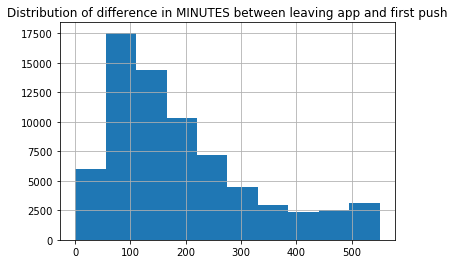

In [89]:
((df[df.diff_secs < df.diff_secs.quantile(.95)].diff_secs)/60).hist();
plt.title('Distribution of difference in MINUTES between leaving app and first push');

Getting rid of outliers for diff_sec

In [28]:
df.head()

,user_id,0,1,2,3,4,5,6,7,hard_news_ratio,D7R,diff_secs,install_dt,active_MAU
0,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.824742,0,7291,2019-10-01,0
1,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.775510,0,7235,2019-10-01,0
2,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806818,0,10731,2019-10-01,0
3,104628725,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806122,0,10921,2019-10-01,0
4,104628795,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.583333,1,10728,2019-10-01,1


In [29]:
df['diff_secs'] = np.where(df.diff_secs > df.diff_secs.quantile(.95), df.diff_secs.quantile(.95), df.diff_secs)

In [30]:
np.mean(df.diff_secs/60)

209.46929097049812

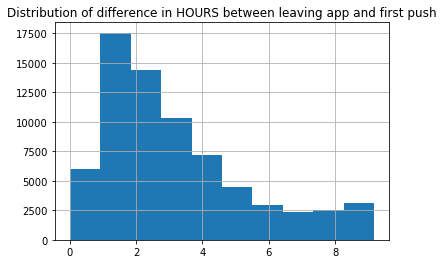

In [88]:
((df[df.diff_secs < df.diff_secs.quantile(.95)].diff_secs)/60/60).hist();
plt.title('Distribution of difference in HOURS between leaving app and first push');

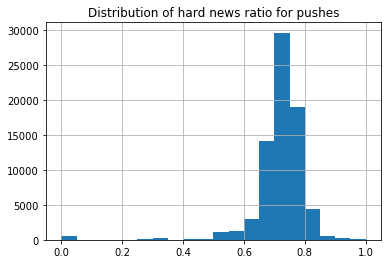

In [87]:
df.hard_news_ratio.hist(bins=20);
plt.title('Distribution of hard news ratio for pushes');

### Finding: Average around 3 hours between leaving the app and getting a push sent. But skewed to the right, some were up to around 6 to 8 hours

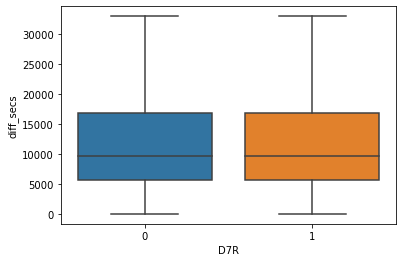

In [167]:
sns.boxplot(y='diff_secs', x='D7R', data=df);

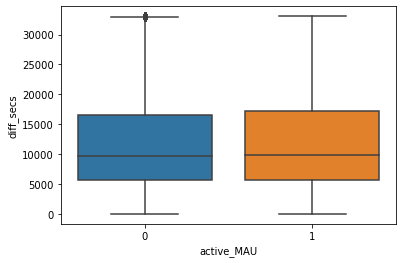

In [33]:
sns.boxplot(y='diff_secs', x='active_MAU', data=df)

### Doesn't appear to be much relationship between time of first push and retention

In [34]:
df.isna().sum()

user_id              0
0                   56
1                   48
2                   39
3                   25
4                   18
5                   13
6                    7
7                    0
hard_news_ratio    129
D7R                  0
diff_secs            0
install_dt           0
active_MAU           0
dtype: int64

In [35]:
df.count()

user_id            74515
0                  74459
1                  74467
2                  74476
3                  74490
4                  74497
5                  74502
6                  74508
7                  74515
hard_news_ratio    74386
D7R                74515
diff_secs          74515
install_dt         74515
active_MAU         74515
dtype: int64

Filling in nulls with 0s

In [37]:
df = df.fillna(0).copy()

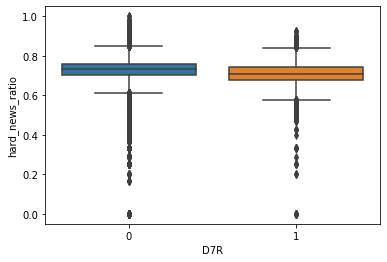

In [46]:
sns.boxplot(x='D7R', y='hard_news_ratio', data=df)

### Appears that fewer hard news pushes has higher D7R

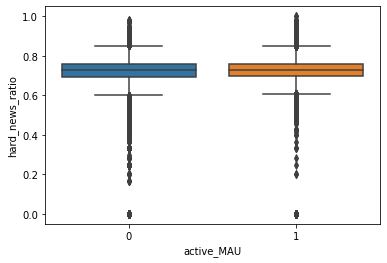

In [77]:
sns.boxplot(x='active_MAU', y='hard_news_ratio', data=df)

### Not much difference for active_MAU

In [67]:
df['total_sent_count'] = df.iloc[:,1:8].sum(axis=1)

### Total sent has same distribution, left skewed, with ~10% of users getting 30 or less for the week

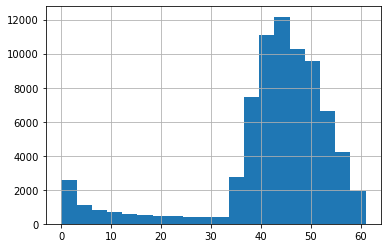

In [79]:
df.total_sent_count.hist(bins=20)

In [92]:
np.mean(df.total_sent_count < 30)

0.10490505267395826

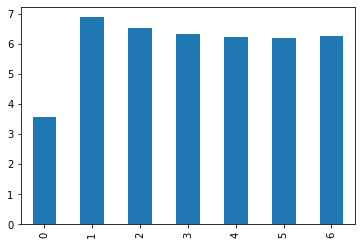

In [84]:
df.iloc[:,1:8].mean().plot(kind='bar')

In [121]:
df.iloc[:,1:].corr()

,0,1,2,3,4,5,6,7,hard_news_ratio,D7R,diff_secs,active_MAU,total_sent_count
0,1.000000,0.062594,0.060107,0.079772,0.057938,0.132305,0.052951,0.070324,0.205209,0.014612,0.087849,0.026723,0.321733
1,0.062594,1.000000,0.289757,0.313230,0.303117,0.309120,0.449412,0.251657,0.391335,0.063988,-0.069251,0.094138,0.595261
2,0.060107,0.289757,1.000000,0.401534,0.351798,0.448027,0.373148,0.532285,0.356734,0.084576,-0.032701,0.127917,0.648680
3,0.079772,0.313230,0.401534,1.000000,0.454455,0.421227,0.464530,0.421656,0.314449,0.088196,-0.037500,0.178950,0.701940
4,0.057938,0.303117,0.351798,0.454455,1.000000,0.515693,0.488810,0.481057,0.323586,0.104360,-0.014633,0.195205,0.711327
5,0.132305,0.309120,0.448027,0.421227,0.515693,1.000000,0.513064,0.534314,0.382787,0.118511,-0.036708,0.225984,0.749460
6,0.052951,0.449412,0.373148,0.464530,0.488810,0.513064,1.000000,0.524267,0.383501,0.121286,-0.012964,0.202017,0.752307
7,0.070324,0.251657,0.532285,0.421656,0.481057,0.534314,0.524267,1.000000,0.372266,0.142172,-0.007376,0.185215,0.631140
hard_news_ratio,0.205209,0.391335,0.356734,0.314449,0.323586,0.382787,0.383501,0.372266,1.000000,-0.050567,-0.067149,0.044487,0.524001
D7R,0.014612,0.063988,0.084576,0.088196,0.104360,0.118511,0.121286,0.142172,-0.050567,1.000000,-0.002686,0.330059,0.133640


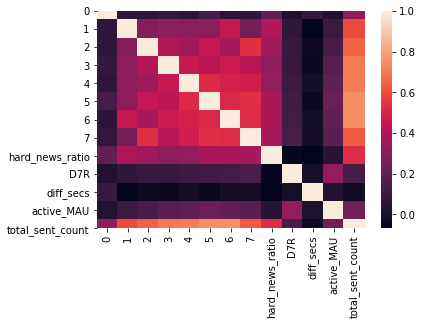

In [124]:
sns.heatmap(df.iloc[:,1:].corr())

### Running classifier model

In [68]:
df.head()

,user_id,0,1,2,3,4,5,6,7,hard_news_ratio,D7R,diff_secs,install_dt,active_MAU,total_sent_count
0,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.824742,0,7291.0,2019-10-01,0,54.0
1,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.775510,0,7235.0,2019-10-01,0,54.0
2,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806818,0,10731.0,2019-10-01,0,55.0
3,104628725,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806122,0,10921.0,2019-10-01,0,55.0
4,104628795,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.583333,1,10728.0,2019-10-01,1,2.0


In [42]:
X = df[[0, 1, 2, 3, 4, 5, 6, 'hard_news_ratio', 'diff_secs']]

In [43]:
y = df.D7R

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
feature_size = [0.2, .3, .4, .5, .6, .7, .8, .9]
cross_val_scores = []
for size in feature_size:
    rf.set_params(max_features = size)
    rf.set_params(n_estimators=40)
    rf.set_params(random_state=2019)
    scores = cross_val_score(estimator = rf, X=X, y=y, cv=10)
    cross_val_scores.append((np.mean(scores), size))
cross_val_scores

[(0.6801449202727814, 0.2),
 (0.6728707828991118, 0.3),
 (0.671448648539064, 0.4),
 (0.6630743316734601, 0.5),
 (0.6638793711550083, 0.6),
 (0.6680934661466497, 0.7),
 (0.6623364674365535, 0.8),
 (0.6643492670331141, 0.9)]

In [48]:
rf.set_params(max_features = 0.2)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=2019,
                       verbose=0, warm_start=False)

In [49]:
importances = pd.DataFrame({
    'variable': X.columns,
    'Weight': rf.feature_importances_
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
7,hard_news_ratio,0.411867
8,diff_secs,0.398905
0,0,0.067826
6,6,0.027963
5,5,0.024240
4,4,0.019876
1,1,0.016719
3,3,0.016671
2,2,0.015934


In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.set_params(max_features = 0.2)
rf.set_params(n_estimators=40)
scores = cross_val_score(estimator = rf, X=X, y=df.active_MAU, cv=10)
scores

array([0.4942976 , 0.36661299, 0.22222222, 0.13097155, 0.13877332,
       0.13568649, 0.12575493, 0.44946987, 0.5725406 , 0.50556972])

In [51]:
scores.mean()

0.314189928842305

In [69]:
rf.set_params(max_features = 0.2)
rf.fit(X, df.active_MAU)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [70]:
importances = pd.DataFrame({
    'variable': X.columns,
    'Weight': rf.feature_importances_
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
8,diff_secs,0.403199
7,hard_news_ratio,0.330729
0,0,0.055909
5,5,0.043711
6,6,0.042137
1,1,0.033536
4,4,0.030840
3,3,0.030244
2,2,0.029694


In [71]:
X = df[[0, 1, 2, 3, 4, 5, 6, 'hard_news_ratio', 'diff_secs', 'total_sent_count']]

In [72]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.set_params(max_features = 0.2)
rf.set_params(n_estimators=40)
scores = cross_val_score(estimator = rf, X=X, y=df.active_MAU, cv=10)
scores

array([0.50476318, 0.37010199, 0.22678476, 0.13285024, 0.14548383,
       0.13273386, 0.12481546, 0.39739632, 0.61495101, 0.4525567 ])

In [73]:
scores.mean()

0.31024373556101753

In [75]:
rf.set_params(max_features = 0.2)
rf.fit(X, df.active_MAU)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
importances = pd.DataFrame({
    'variable': X.columns,
    'Weight': rf.feature_importances_
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
8,diff_secs,0.400574
7,hard_news_ratio,0.321231
9,total_sent_count,0.057584
6,6,0.040811
5,5,0.035853
2,2,0.032507
0,0,0.031324
1,1,0.027474
4,4,0.027352
3,3,0.025289


In [93]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

In [94]:
scores = cross_val_score(estimator = logreg, X=X, y=df.D7R, cv=10)

In [95]:
scores

array([0.81535158, 0.81535158, 0.81535158, 0.81521739, 0.81521739,
       0.81535158, 0.81546101, 0.8153268 , 0.81546101, 0.81543624])

### Trying logistic regression

In [132]:
from sklearn.preprocessing import StandardScaler

In [126]:
import statsmodels.api as sm

In [133]:
X = sc.fit_transform(X)

In [142]:
X

array([[ 1.92758428,  1.20945861,  0.17465072, ...,  1.18247934,
        -0.58688155,  0.94489204],
       [ 1.92758428,  1.20945861,  0.17465072, ...,  0.64399486,
        -0.5931094 ,  0.94489204],
       [ 1.92758428,  1.20945861,  0.17465072, ...,  0.98643145,
        -0.20431337,  1.02369834],
       ...,
       [-1.26266629,  0.04420806, -0.9182057 , ..., -0.3074258 ,
        -0.5816546 , -0.2372026 ],
       [-1.26266629,  0.04420806, -0.9182057 , ..., -0.23752678,
        -0.59588969, -0.2372026 ],
       [-1.26266629, -0.3442088 , -0.9182057 , ..., -0.54650074,
         0.19805049, -1.41929724]])

In [143]:
X = pd.DataFrame(X)

In [144]:
X.columns = df[[0, 1, 2, 3, 4, 5, 6, 'hard_news_ratio', 'diff_secs', 'total_sent_count']].columns

In [156]:
logit_model = sm.Logit(df.active_MAU,X)

In [157]:
result = logit_model.fit()

         Current function value: 0.656764
         Iterations: 35


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [158]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             active_MAU   No. Observations:                74515
Model:                          Logit   Df Residuals:                    74506
Method:                           MLE   Df Model:                            8
Date:                Mon, 06 Jan 2020   Pseudo R-squ.:                -0.02300
Time:                        18:41:29   Log-Likelihood:                -48939.
converged:                      False   LL-Null:                       -47839.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
0                   -0.0144   1.55e+05  -9.33e-08      1.000   -3.03e+05    3.03e+05
1                   -0.0282   1.41e+05     -2e-07      1.000   -2.77e+05    2.77e+05
2                    0.0034 

In [165]:
logit_model = sm.Logit(df.D7R,X)
result = logit_model.fit()
print(result.summary())

         Current function value: 0.680790
         Iterations: 35


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                    D7R   No. Observations:                74515
Model:                          Logit   Df Residuals:                    74506
Method:                           MLE   Df Model:                            8
Date:                Mon, 06 Jan 2020   Pseudo R-squ.:                 -0.4233
Time:                        18:42:23   Log-Likelihood:                -50729.
converged:                      False   LL-Null:                       -35641.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
0                    0.0215        nan        nan        nan         nan         nan
1                    0.0392        nan        nan        nan         nan         nan
2                    0.0551 

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [159]:
logreg.fit(X, df.active_MAU)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [160]:
X.columns

Index([0, 1, 2, 3, 4, 5, 6, 'hard_news_ratio', 'diff_secs',
       'total_sent_count'],
      dtype='object')

In [161]:
logreg.coef_[0]

array([-0.03152868, -0.02849167,  0.04477343,  0.17517926,  0.19779484,
        0.36094793,  0.25093927, -0.32795447,  0.04356369,  0.22259784])

In [162]:
importances = pd.DataFrame({
    'variable': X.columns,
    'Weight': logreg.coef_[0]
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
5,5,0.360948
6,6,0.250939
9,total_sent_count,0.222598
4,4,0.197795
3,3,0.175179
2,2,0.044773
8,diff_secs,0.043564
1,1,-0.028492
0,0,-0.031529
7,hard_news_ratio,-0.327954


In [163]:
importances = pd.DataFrame({
    'variable': X.columns,
    'Weight_absolute': importances.Weight.abs()
})
importances.sort_values(by='Weight_absolute',ascending=False)

,variable,Weight_absolute
5,5,0.360948
7,hard_news_ratio,0.327954
6,6,0.250939
9,total_sent_count,0.222598
4,4,0.197795
3,3,0.175179
2,2,0.044773
8,diff_secs,0.043564
0,0,0.031529
1,1,0.028492


In [169]:
df.head()

,user_id,0,1,2,3,4,5,6,7,hard_news_ratio,D7R,diff_secs,install_dt,active_MAU,total_sent_count
0,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.824742,0,7291.0,2019-10-01,0,54.0
1,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,10.0,0.775510,0,7235.0,2019-10-01,0,54.0
2,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806818,0,10731.0,2019-10-01,0,55.0
3,104628725,9.0,10.0,7.0,11.0,4.0,6.0,8.0,10.0,0.806122,0,10921.0,2019-10-01,0,55.0
4,104628795,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.583333,1,10728.0,2019-10-01,1,2.0


### Checking F1 score and AUC for logreg

In [180]:
trainX, testX, trainy, testy = train_test_split(X, df.D7R, test_size=0.5, random_state=2)

In [181]:
logreg.fit(trainX, trainy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [183]:
lr_probs = logreg.predict_proba(testX)

In [184]:
pd.DataFrame(lr_probs)

,0,1
0,0.894146,0.105854
1,0.758614,0.241386
2,0.568394,0.431606
3,0.871873,0.128127
4,0.840649,0.159351
...,...,...
37253,0.832338,0.167662
37254,0.745875,0.254125
37255,0.831506,0.168494
37256,0.800046,0.199954


In [185]:
lr_probs = lr_probs[:, 1]

In [186]:
yhat = logreg.predict(testX)

In [187]:
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)

In [188]:
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)

In [189]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.004 auc=0.277


In [190]:
no_skill = len(testy[testy==1]) / len(testy)

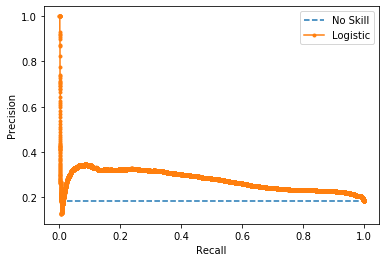

In [199]:
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill');
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic');
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Looks pretty bad

In [211]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
scoring = make_scorer(f1_score)

In [205]:
import sklearn.model_selection

In [222]:
scores = cross_val_score(estimator = logreg, X=X, y=df.D7R, scoring=scoring, cv=2)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [223]:
scores

array([0.27003041, 0.        ])

### I guess I dont have enough positive results to cross validate?

### 3rd model - actually try to predict with user actions - push opens, PVs, timespent, CTR, first 6 days etc?

https://jupyter.smartnews.be/user/sn/notebooks/push-notification/2020-01-02-DEVON-PUSH-new_user_activation_project-PART-3.ipynb

UsageError: Cell magic `%%class` not found.
